In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Image Clustering

In [ ]:
from warnings import filterwarnings
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam,Adadelta,RMSprop,Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import numpy as np
import argparse
import cv2
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import StratifiedKFold
import scipy
import skimage
from skimage.transform import resize
import random
import os
import seaborn as sns
from tqdm import tqdm


# Import the necessary packages
from __future__ import print_function
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
import cv2 as cv
from matplotlib import pyplot as plt
from skimage import data, io
from skimage.util import img_as_ubyte
from skimage.io import imshow, imread
from skimage.color import rgb2hsv, hsv2rgb
import matplotlib.patches as mpatches
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.filters import threshold_mean

In [ ]:
labels = ['REDAFB','FUNGI','BLUEAFB','ARTEFACT']

In [ ]:
X_train = []
y_train = []
IMG_SIZE= 64

for i in labels:
    folderPath = os.path.join('/content/gdrive/MyDrive/Project New','Dataset-ver-2',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(IMG_SIZE, IMG_SIZE))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 81/81 [00:39<00:00,  2.04it/s]


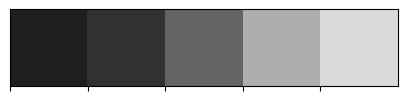

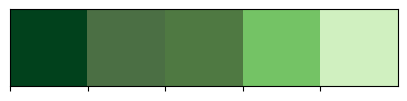

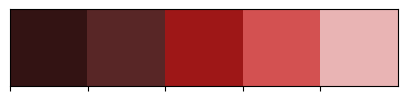

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)


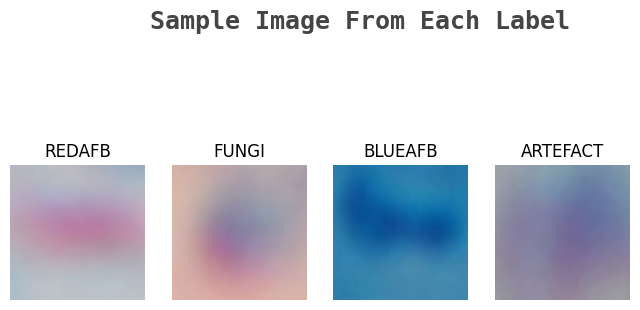

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(8,8))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.75,x=0.3,alpha=0.9)

for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=0)

X_train = X_train.astype('float32') #set x_train data type as float32
X_test = X_test.astype('float32') #set x_test data type as float32
X_train /= 255 #change x_train value between 0 - 1
X_test /= 255 #change x_test value between 0 - 1

In [ ]:
print('X_train:',len(X_train))
print('X_test:',len(X_test))
y_train_new = []

for i in y_train:
    y_train_new.append(labels.index(i))
    y_train = y_train_new
    y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []

for i in y_test:
    y_test_new.append(labels.index(i))
    y_test = y_test_new
    y_test = tf.keras.utils.to_categorical(y_test)

X_train: 377
X_test: 95


In [ ]:
input_shape = (64,64,3)
# load base model
vgg = VGG19(weights='imagenet', input_shape=input_shape, include_top=False)


80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
model = vgg.output
model = tf.keras.layers.GlobalMaxPooling2D()(model)
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(64,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.25)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=vgg.input, outputs = model)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
#COMPILE
# Learning Rate
#COMPILE
# Learning Rate
initial_learning_rate = 0.0001

# Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=755,
    decay_rate=0.9,
    staircase=True)

adam = Adam(lr_schedule)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model1 = vgg
for i in range(len(model1.layers)):
    layer = model1.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i , layer.name , layer.output.shape)

1 block1_conv1 (None, 64, 64, 64)
2 block1_conv2 (None, 64, 64, 64)
4 block2_conv1 (None, 32, 32, 128)
5 block2_conv2 (None, 32, 32, 128)
7 block3_conv1 (None, 16, 16, 256)
8 block3_conv2 (None, 16, 16, 256)
9 block3_conv3 (None, 16, 16, 256)
10 block3_conv4 (None, 16, 16, 256)
12 block4_conv1 (None, 8, 8, 512)
13 block4_conv2 (None, 8, 8, 512)
14 block4_conv3 (None, 8, 8, 512)
15 block4_conv4 (None, 8, 8, 512)
17 block5_conv1 (None, 4, 4, 512)
18 block5_conv2 (None, 4, 4, 512)
19 block5_conv3 (None, 4, 4, 512)
20 block5_conv4 (None, 4, 4, 512)


In [ ]:
#Understand the filters in the model
#Let us pick the first hidden layer as the layer of interest.
layers = model1.layers #Conv layers at 1, 3, 6, 8, 11, 13, 15
filters, biases = model1.layers[1].get_weights()
layer_outputs = model1.layers[1].output
model1_Input = model1.input
print('Layer Name is :', layers[1].name, '\nFitler Shaper:',filters.shape)

Layer Name is : block1_conv1 
Fitler Shaper: (3, 3, 3, 64)


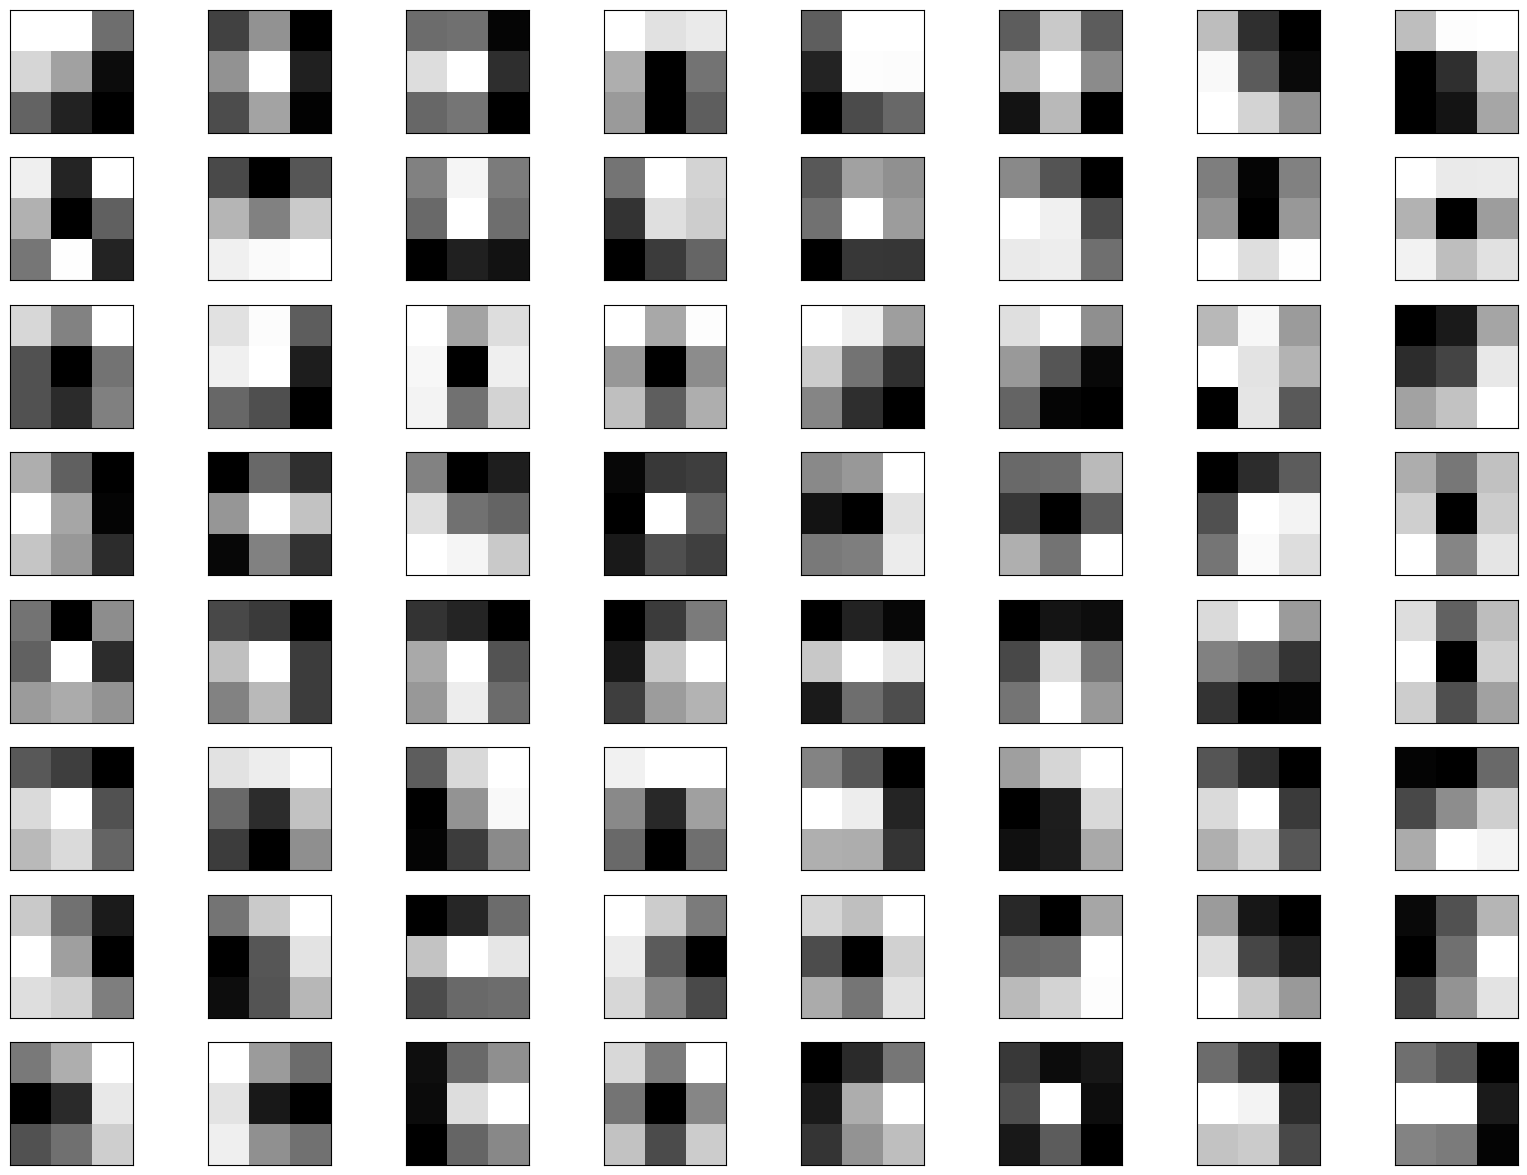

In [ ]:
# plot filters

fig1=plt.figure(figsize=(20, 15))
columns = 8
rows = 8
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
#plt.show()

In [ ]:
checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/Project New/Model Save Training/BEST_TRAINING_MODEL_1.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=0)

history= model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=100,
          batch_size=30,
          callbacks=checkpoint)
#batch_size=15,Datatrain =107,  107/15=8step
#batch_size=15,Datatest =27,

Epoch 1/100
13/13 [==============================] - 20s 250ms/step - loss: 1.2272 - accuracy: 0.4111 - val_loss: 1.1170 - val_accuracy: 0.4000
Epoch 2/100
13/13 [==============================] - 1s 108ms/step - loss: 1.0577 - accuracy: 0.5146 - val_loss: 0.9504 - val_accuracy: 0.5895
Epoch 3/100
13/13 [==============================] - 1s 109ms/step - loss: 1.0407 - accuracy: 0.5146 - val_loss: 0.9486 - val_accuracy: 0.6000
Epoch 4/100
13/13 [==============================] - 1s 109ms/step - loss: 0.9493 - accuracy: 0.6260 - val_loss: 0.8427 - val_accuracy: 0.6842
Epoch 5/100
13/13 [==============================] - 1s 61ms/step - loss: 0.8808 - accuracy: 0.6552 - val_loss: 0.7783 - val_accuracy: 0.6737
Epoch 6/100
13/13 [==============================] - 1s 61ms/step - loss: 0.7734 - accuracy: 0.6552 - val_loss: 0.7153 - val_accuracy: 0.6842
Epoch 7/100
13/13 [==============================] - 1s 111ms/step - loss: 0.7351 - accuracy: 0.6684 - val_loss: 0.6711 - val_accuracy: 0.7474


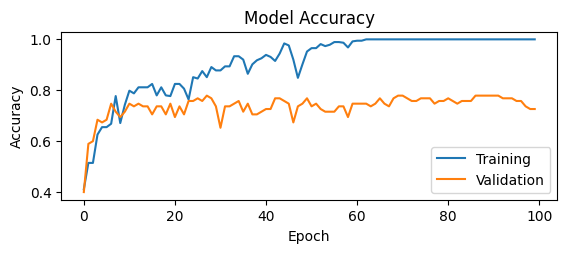

In [ ]:
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

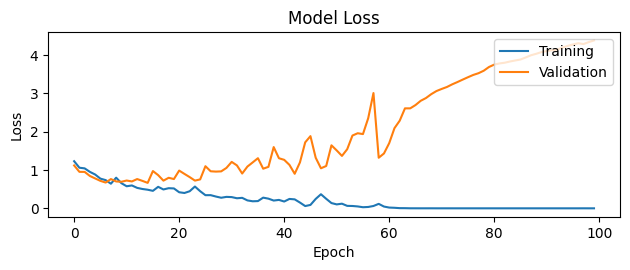

In [ ]:
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/MyDrive/Project New/Model Save Training/BEST_TRAINING_MODEL_1.h5')

In [ ]:
results = model.evaluate(X_test, y_test, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.95683
Test Accuracy: 77.89%


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

3/3 [==============================] - 0s 22ms/step


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_new,pred))
confusion_matrix(y_test_new,pred)

0.7789473684210526


array([[39,  0,  0,  0],
       [10, 25,  0,  3],
       [ 0,  0,  2,  0],
       [ 2,  4,  2,  8]])

In [ ]:
print(classification_report(y_test_new,pred,target_names=labels))

              precision    recall  f1-score   support

      REDAFB       0.76      1.00      0.87        39
       FUNGI       0.86      0.66      0.75        38
     BLUEAFB       0.50      1.00      0.67         2
    ARTEFACT       0.73      0.50      0.59        16

    accuracy                           0.78        95
   macro avg       0.71      0.79      0.72        95
weighted avg       0.79      0.78      0.77        95



<Axes: >

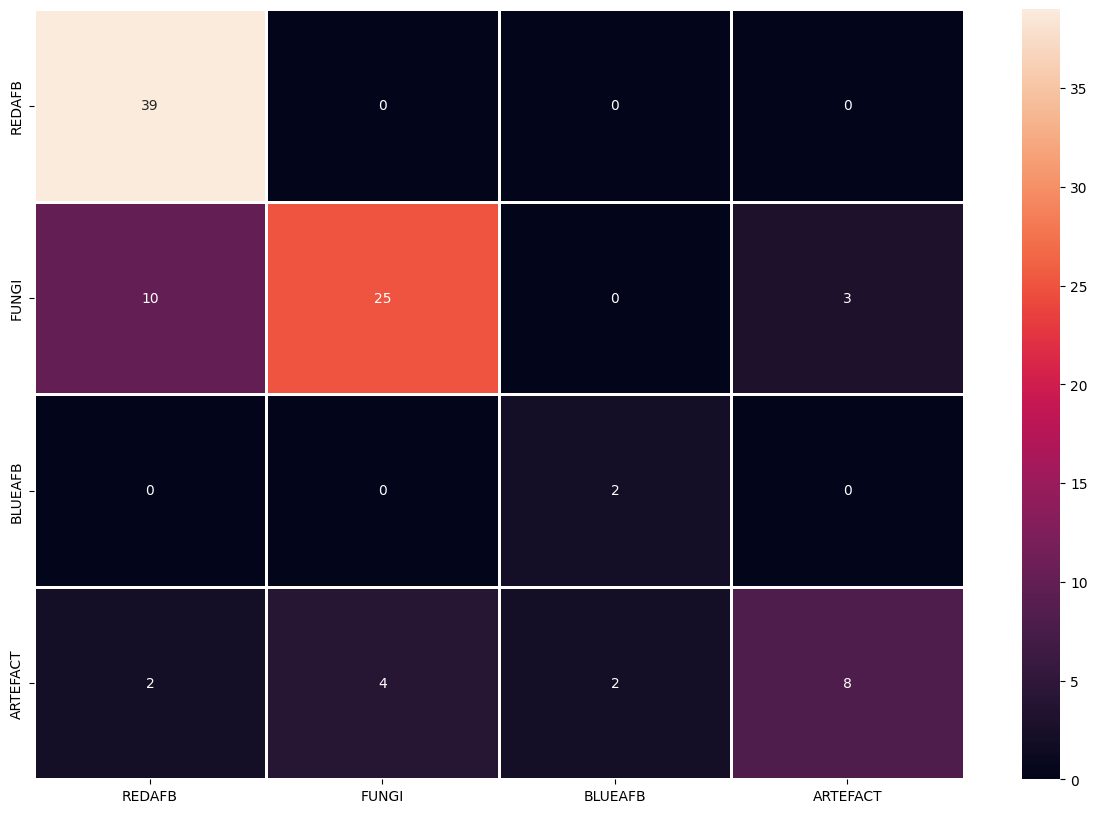

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(confusion_matrix(y_test_new,pred), linewidths=1, xticklabels=['REDAFB','FUNGI','BLUEAFB','ARTEFACT'], yticklabels=['REDAFB','FUNGI','BLUEAFB','ARTEFACT'], annot=True, ax=ax, fmt='g')

In [ ]:
ind_list = np.argwhere((y_test_new == pred) == False)[:, -1]

if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_test_new[i]}\nPredicted class: {pred[i]}')
        plt.show()

In [ ]:
#-----------------FOLDER INFORMATION----------------
import os
from keras.preprocessing import image
# getting & setting (chapter-4)
#Import the necessary packages
from __future__ import print_function
import argparse
import cv2
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib import pyplot as plt
from skimage import data, io
from skimage.util import img_as_ubyte
from PIL import Image

def key_func(x):
  return os.path.split(x)[-1]
initial_count = 0

dir ="/content/gdrive/MyDrive/Project New/Dataset/AFB_TEST/Scanty_25014801A-367"


folderPath = os.path.join(dir)


for path in sorted(os.listdir(dir)):
  img =io.imread(os.path.join(dir, path))
  ori =io.imread(os.path.join(dir, path))
  img= cv2.resize(img, (64, 64))
  img = np.asarray(img)
  #plt.imshow(img),plt.title("Predicted Result"), plt.axis('off')
  img = np.expand_dims(img, axis=0)

  output = model.predict(img)

  if output[0][0] > output[0][1]:
    print('REDAFB')
  elif output[0][1] > output[0][2]:
    print('FUNGI')
  elif output[0][2] > output[0][2]:
    print('BLUEAFB')
  else:
    print('ARTEFACT')

  initial_count += 1

'''
  if os.path.isfile(os.path.join(dir, path)):
    plt.figure(num=None, figsize=(16,16))
    plt.subplot(1,2,1), plt.title(os.path.basename(path)), plt.imshow(ori), plt.axis('off')
    #plt.subplot(1,2,2), plt.title("Predicted Result"), plt.imshow(img), plt.axis('off')
    # show the output image
'''
print(" ")
print("===================================")
for label_pred in output:
  print(label_pred[0].count())
#print("Red Afb:", len(label_1))
print("Path ID:",os.path.basename(dir))
print("Number of Datasets:",initial_count)

1/1 [==============================] - 0s 31ms/step
ARTEFACT
1/1 [==============================] - 0s 22ms/step
ARTEFACT
1/1 [==============================] - 0s 31ms/step
FUNGI
1/1 [==============================] - 0s 20ms/step
FUNGI
1/1 [==============================] - 0s 20ms/step
ARTEFACT
1/1 [==============================] - 0s 20ms/step
ARTEFACT
1/1 [==============================] - 0s 19ms/step
FUNGI
1/1 [==============================] - 0s 19ms/step
ARTEFACT
1/1 [==============================] - 0s 22ms/step
REDAFB
1/1 [==============================] - 0s 22ms/step
REDAFB
1/1 [==============================] - 0s 20ms/step
ARTEFACT
1/1 [==============================] - 0s 21ms/step
FUNGI
1/1 [==============================] - 0s 20ms/step
ARTEFACT
1/1 [==============================] - 0s 21ms/step
ARTEFACT
1/1 [==============================] - 0s 20ms/step
FUNGI
1/1 [==============================] - 0s 21ms/step
ARTEFACT
1/1 [==============================] - 0s 2

AttributeError: ignored

In [ ]:
print(output)

[[0.03165429 0.96834564 0.         0.        ]]


In [ ]:
print(label1)

[]


In [ ]:
#-----------------FOLDER INFORMATION----------------
import os
from keras.preprocessing import image
# getting & setting (chapter-4)
#Import the necessary packages
from __future__ import print_function
import argparse
import cv2
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib import pyplot as plt
from skimage import data, io
from skimage.util import img_as_ubyte
from PIL import Image

def key_func(x):
  return os.path.split(x)[-1]
initial_count = 0

dir ="/content/gdrive/MyDrive/Project New/Dataset/AFB_TEST/Scanty_25014801A-367"


folderPath = os.path.join(dir)

for path in sorted(os.listdir(dir)):
  img =io.imread(os.path.join(dir, path))
  ori =io.imread(os.path.join(dir, path))
  img= cv2.resize(img, (64, 64))
  img = np.asarray(img)
  #plt.imshow(img),plt.title("Predicted Result"), plt.axis('off')
  img = np.expand_dims(img, axis=0)

  output = model.predict(img)

  #get score
  score = tf.nn.softmax(output[0])

  print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
  )

  initial_count += 1
'''
  if os.path.isfile(os.path.join(dir, path)):
    plt.figure(num=None, figsize=(16,16))
    plt.subplot(1,2,1), plt.title(os.path.basename(path)), plt.imshow(ori), plt.axis('off')
    #plt.subplot(1,2,2), plt.title("Predicted Result"), plt.imshow(img), plt.axis('off')
    # show the output image
'''


print(" ")
print("===================================")
print("Path ID:",os.path.basename(dir))
print("Number of Datasets:",initial_count)

1/1 [==============================] - 1s 550ms/step
This image most likely belongs to ARTEFACT with a 47.54 percent confidence.
1/1 [==============================] - 0s 20ms/step
This image most likely belongs to ARTEFACT with a 47.54 percent confidence.
1/1 [==============================] - 0s 19ms/step
This image most likely belongs to FUNGI with a 47.54 percent confidence.
1/1 [==============================] - 0s 21ms/step
This image most likely belongs to ARTEFACT with a 47.54 percent confidence.
1/1 [==============================] - 0s 21ms/step
This image most likely belongs to ARTEFACT with a 47.54 percent confidence.
1/1 [==============================] - 0s 20ms/step
This image most likely belongs to ARTEFACT with a 47.54 percent confidence.
1/1 [==============================] - 0s 20ms/step
This image most likely belongs to FUNGI with a 47.54 percent confidence.
1/1 [==============================] - 0s 20ms/step
This image most likely belongs to ARTEFACT with a 47.54 p

In [ ]:
#image url
afb_path= "/content/gdrive/MyDrive/Project New/Dataset/AFB_TEST/Scanty_25014801A-367/99.jpg"

#load image
img = tf.keras.utils.load_img(
    afb_path, target_size=(64, 64)
)
# image to array
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

#make prediction
predictions = model.predict(img_array)
#get score
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 24ms/step
This image most likely belongs to FUNGI with a 47.54 percent confidence.


# Simillarity Using VGG-19

In [ ]:
from DeepImageSearch import Load_Data, Search_Setup

# Load images from a folder
image_list = Load_Data().from_folder(['folder_path'])

 # Set up the search engine, You can load 'vit_base_patch16_224_in21k', 'resnet50' etc more then 500+ models
 st = Search_Setup(image_list=image_list, model_name='vgg19', pretrained=True, image_count=100)

# Index the images
st.run_index()

# Get metadata
metadata = st.get_image_metadata_file()

# Add new images to the index
st.add_images_to_index(['image_path_1', 'image_path_2'])

# Get similar images
st.get_similar_images(image_path='image_path', number_of_images=10)

# Plot similar images
st.plot_similar_images(image_path='image_path', number_of_images=9)

# Update metadata
metadata = st.get_image_metadata_file()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install DeepImageSearch --upgrade

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.6 MB/s eta 0:00:00
  Created wheel for DeepImageSearch: filename=DeepImageSearch-2.5-py3-none-any.whl size=8457 sha256=130761def87453a83e4b735864dfb60c2d203df66f0b0299edb80b5adb0ba491
  Stored in directory: /root/.cache/pip/wheels/50/e6/4e/3c57c420e1fa20cba29a168f084e77129b0299c7fd6cdd08b5
Successfully built DeepImageSearch


In [ ]:
from DeepImageSearch import Load_Data, Search_Setup

In [ ]:
image_list = Load_Data().from_folder(['/content/gdrive/MyDrive/yolov7/crop'])

In [ ]:
print("Total Image Count:",len(image_list))
print("Samples:")
print(image_list[:20])

Total Image Count: 16
Samples:
['/content/gdrive/MyDrive/yolov7/crop/0.jpg', '/content/gdrive/MyDrive/yolov7/crop/1.jpg', '/content/gdrive/MyDrive/yolov7/crop/2.jpg', '/content/gdrive/MyDrive/yolov7/crop/3.jpg', '/content/gdrive/MyDrive/yolov7/crop/4.jpg', '/content/gdrive/MyDrive/yolov7/crop/5.jpg', '/content/gdrive/MyDrive/yolov7/crop/6.jpg', '/content/gdrive/MyDrive/yolov7/crop/7.jpg', '/content/gdrive/MyDrive/yolov7/crop/8.jpg', '/content/gdrive/MyDrive/yolov7/crop/9.jpg', '/content/gdrive/MyDrive/yolov7/crop/10.jpg', '/content/gdrive/MyDrive/yolov7/crop/11.jpg', '/content/gdrive/MyDrive/yolov7/crop/12.jpg', '/content/gdrive/MyDrive/yolov7/crop/13.jpg', '/content/gdrive/MyDrive/yolov7/crop/14.jpg', '/content/gdrive/MyDrive/yolov7/crop/15.jpg']


In [ ]:
st = Search_Setup(image_list=image_list, model_name='vgg19', pretrained=True, image_count=100)

 Please Wait Model Is Loading or Downloading From Server!


 Model Loaded Successfully: vgg19


In [ ]:
st.run_index()

100%|██████████| 16/16 [00:37<00:00,  2.32s/it]

 Image Meta Information Saved: [metadata-files/vgg19/image_data_features.pkl]
 Saved The Indexed File:[metadata-files/vgg19/image_features_vectors.idx]


In [ ]:
metadata = st.get_image_metadata_file()
metadata

,images_paths,features
0,/content/gdrive/MyDrive/yolov7/crop/0.jpg,"[0.04611149, 0.0, 0.0, 0.045365978, 0.03638147..."
1,/content/gdrive/MyDrive/yolov7/crop/1.jpg,"[0.053451106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
2,/content/gdrive/MyDrive/yolov7/crop/2.jpg,"[0.049192894, 0.0, 0.0, 0.03320382, 0.01888238..."
3,/content/gdrive/MyDrive/yolov7/crop/3.jpg,"[0.055510003, 0.0, 0.0, 0.069446854, 0.0228206..."
4,/content/gdrive/MyDrive/yolov7/crop/4.jpg,"[0.014763761, 0.0, 0.0, 0.046426587, 0.0, 0.0,..."
5,/content/gdrive/MyDrive/yolov7/crop/5.jpg,"[0.04612276, 0.0, 0.0, 0.06913388, 0.01536684,..."
6,/content/gdrive/MyDrive/yolov7/crop/6.jpg,"[0.049837805, 0.0, 0.0, 0.068007916, 0.0085860..."
7,/content/gdrive/MyDrive/yolov7/crop/7.jpg,"[0.054636054, 0.0, 0.0, 0.009778524, 0.0036101..."
8,/content/gdrive/MyDrive/yolov7/crop/8.jpg,"[0.039224137, 0.0, 0.0, 0.0, 0.023795743, 0.0,..."
9,/content/gdrive/MyDrive/yolov7/crop/9.jpg,"[0.023480369, 0.0, 0.0, 0.011582497, 0.0066575..."


In [ ]:
st.get_similar_images(image_path=image_list[1],number_of_images=16)

{1: '/content/gdrive/MyDrive/yolov7/crop/1.jpg',
 14: '/content/gdrive/MyDrive/yolov7/crop/14.jpg',
 7: '/content/gdrive/MyDrive/yolov7/crop/7.jpg',
 15: '/content/gdrive/MyDrive/yolov7/crop/15.jpg',
 2: '/content/gdrive/MyDrive/yolov7/crop/2.jpg',
 10: '/content/gdrive/MyDrive/yolov7/crop/10.jpg',
 13: '/content/gdrive/MyDrive/yolov7/crop/13.jpg',
 6: '/content/gdrive/MyDrive/yolov7/crop/6.jpg',
 3: '/content/gdrive/MyDrive/yolov7/crop/3.jpg',
 8: '/content/gdrive/MyDrive/yolov7/crop/8.jpg',
 5: '/content/gdrive/MyDrive/yolov7/crop/5.jpg',
 0: '/content/gdrive/MyDrive/yolov7/crop/0.jpg',
 11: '/content/gdrive/MyDrive/yolov7/crop/11.jpg',
 4: '/content/gdrive/MyDrive/yolov7/crop/4.jpg',
 9: '/content/gdrive/MyDrive/yolov7/crop/9.jpg',
 12: '/content/gdrive/MyDrive/yolov7/crop/12.jpg'}

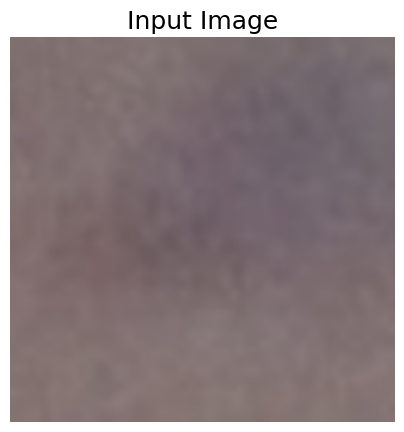

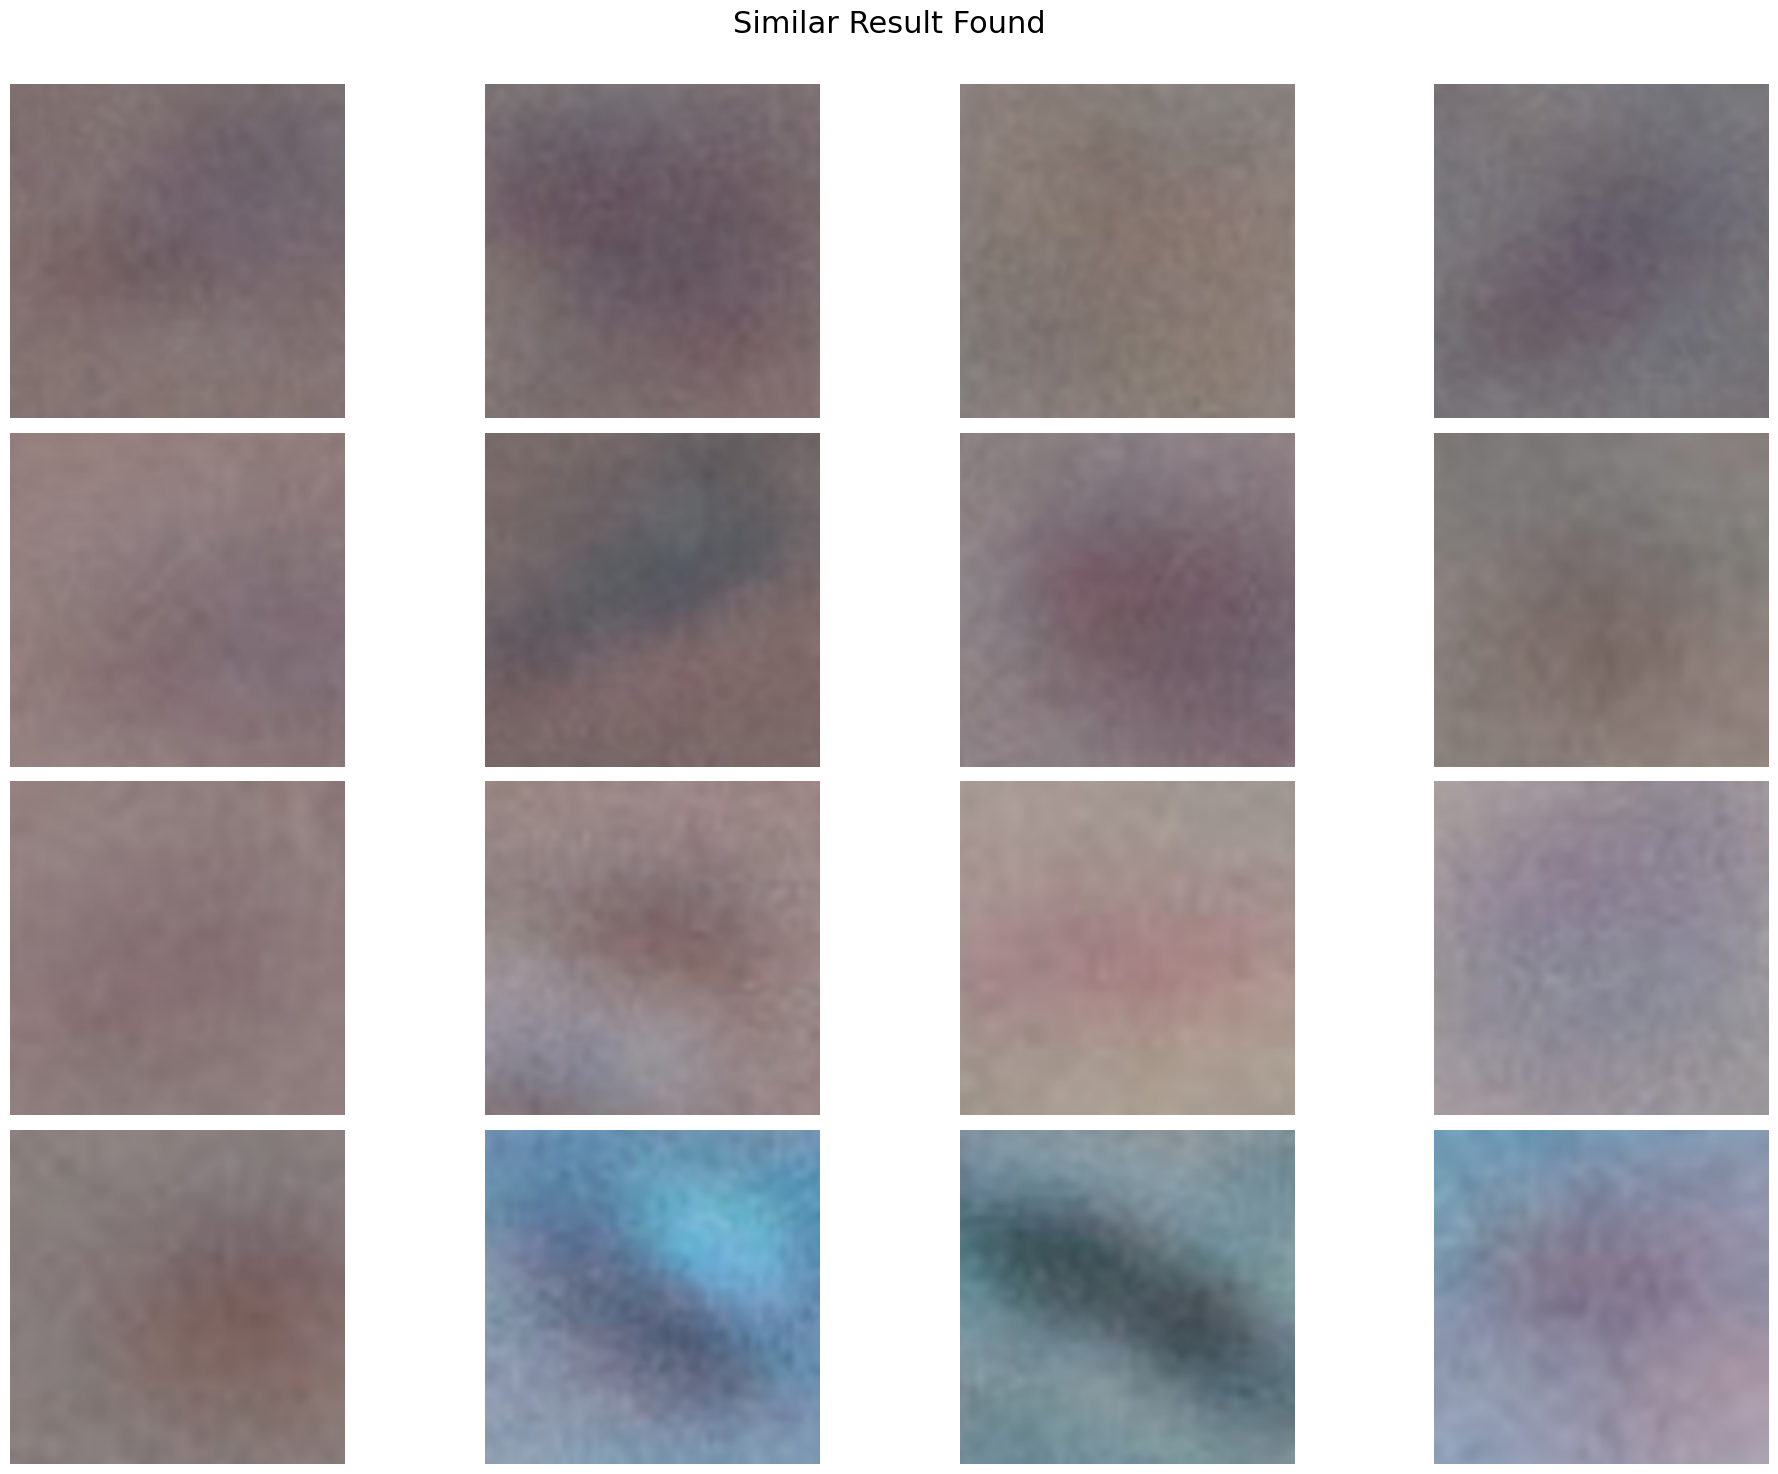

In [ ]:
st.plot_similar_images(image_path = image_list[1],number_of_images=16)